In [1]:
import pandas
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from statannot import add_stat_annotation
from tqdm import tqdm
from scipy.optimize import curve_fit
import copy

# Functions

In [2]:
def CasFilterProperties_(data_cas,data_cell,deltat,radius,threshold_P):
    
    # we cut to caspase and only deltat frames before - > cells that don't have that length are thrown out

 
    #1) find matching data (date,type and well)
    #3) only take data up to  frames befor hitting 
    #4) note that date and well is not unique since one well can have several not related caspase events
    
    count=0
        
    for d in data_cas.date.unique():
        df1=data_cas.loc[data_cas.date == d].copy()
        for w in data_cas.well.unique():
                df_cas = df1.loc[df1.well == w]
    
                #can have several entries because several caspases per well
                count_loc=0
                for foo,row in df_cas.iterrows():
                    count_loc=count_loc+1
                    df_cell = data_cell.loc[(data_cell.well==w) & (data_cell.date == d) ].copy()
                    #distance to caspase event   
                    df_cell['dist']= np.sqrt( (df_cell.x - row.x) **2  + ( df_cell.y -  row.y)**2 )    
                    df_cell['oIT']= ( row.hitting-deltat < df_cell['frame']) & (df_cell['frame']<= row.hitting) 
                    df_cell['oID']= df_cell['dist']<=radius
                    
                    df_cell['oI']= df_cell['oIT'] &  df_cell['oID']
                    df_cell.oI = df_cell.oI.replace({True: 1, False: 0})
                    
                    for part in df_cell.particle.unique():
                        df=df_cell[df_cell.particle==part]

                        if(df.oI.sum() >=5):#only cells with at least 5 frames
                        
                            new_df={'particle':part,'date':d,'well':w,'event':count_loc,'count_frames':len(df[df.oI==1].EP),'frames_P_g': len(df[(df.oI==1) & (df.EP > threshold_P)])}
           
    
                            if(count == 0):
                                out=pandas.DataFrame(new_df,index=[0])
                                count=1
                            else:  
                                out=pandas.concat([out,pandas.DataFrame(new_df,index=[0])])
                    
                    
    return out 

# Load data

In [3]:
data_PI_casp = pandas.read_csv(r'Data\Fig_S5_PI.csv')

In [4]:
data_on_spheroid = pandas.read_csv('Data/Trajectories_on_spheroids.csv')
tracks_wt = data_on_spheroid.loc[data_on_spheroid.type == 'wt'].reset_index(drop = True)
tracks_apc = data_on_spheroid.loc[data_on_spheroid.type == 'apc'].reset_index(drop = True)

In [5]:
data_with_EP = pandas.read_csv('Data/Trajectories_with_EP.csv')
EP_wt = data_with_EP.loc[data_with_EP.type == 'wt'].reset_index(drop = True)
EP_apc = data_with_EP.loc[data_with_EP.type == 'apc'].reset_index(drop = True)

In [6]:
individual_nucleation = pandas.read_csv('Data/individual_killing.csv')
caspase_nucleation = pandas.read_csv('Data/cascade_killing.csv')

# PI vs caspase cascade

C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


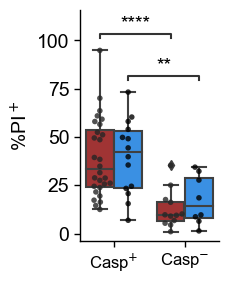

In [7]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1, figsize = (1.8,3))

order = ['Casp+', 'Casp-']
hue_order = ['APC', 'WT']

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)        
ax.tick_params(width=1, length=4)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

sns.boxplot(ax = ax,
            data=data_PI_casp,
            x = 'caspase',
            y='percent_dead',
            hue = 'type',
            order = order,
            hue_order = hue_order,
            palette = ['firebrick', 'dodgerblue'])

sns.swarmplot(data=data_PI_casp,
              x = 'caspase',
              y='percent_dead',
              color = 'k',
              hue = 'type',
              hue_order = hue_order,
              dodge = True,
              size=4,
              alpha = 0.8,
              order = order)
add_stat_annotation(ax = ax,
                    data=data_PI_casp,
                    x = 'caspase',
                    y='percent_dead',
                    hue = 'type',
                    order = order,
                    hue_order = hue_order,
                    box_pairs=[(('Casp+','WT'), ('Casp-','WT')), (('Casp+','APC'), ('Casp-','APC'))],
                    test='t-test_welch', 
                    comparisons_correction=None, 
                    fontsize = 14,
                    text_format='star', loc='inside', verbose=0)

ax.set_ylabel(r'%PI$^+$', fontsize=14)
ax.set_xlabel(' ', fontsize=14)
ax.get_legend().remove()
labels = [r'Casp$^{+}$', r'Casp$^{-}$']
ax.set_xticklabels(labels, fontsize = 12)
plt.show()

# Comparison cascade and individual killing

In [8]:
R = 50
time_thresh = 5
time_before = 80

In [9]:
individual_nucleation['event'] = [i for i in range(len(individual_nucleation))]
individual_nucleation_apc = individual_nucleation.loc[individual_nucleation.type == 'apc']
individual_nucleation_wt = individual_nucleation.loc[individual_nucleation.type == 'wt']

for event in individual_nucleation_apc.event.unique(): 
    x_casp = individual_nucleation_apc.loc[individual_nucleation_apc.event == event, 'x'].item()
    y_casp = individual_nucleation_apc.loc[individual_nucleation_apc.event == event, 'y'].item()
    date = individual_nucleation_apc.loc[individual_nucleation_apc.event == event, 'date'].item()
    well = individual_nucleation_apc.loc[individual_nucleation_apc.event == event, 'well'].item()
    hitting = individual_nucleation_apc.loc[individual_nucleation_apc.event == event, 'hitting'].item()
    
    df = copy.copy(tracks_apc.loc[(tracks_apc.date == date) & (tracks_apc.well == well) & (tracks_apc.frame <= hitting)])
    df['dist_to_caspase'] = np.nan
    df['dist_to_caspase'] = np.sqrt((np.array(df['x']) - x_casp)**2 + (np.array(df['y']) - y_casp)**2)
    
    df['time_to_casp'] = np.nan
    df['time_to_casp'] = df.frame - hitting
   
    part, counts = np.unique(np.array(df.loc[(df.dist_to_caspase <= R) & (df.time_to_casp > -time_before)].particle), return_counts = True)   
    individual_nucleation_apc.loc[individual_nucleation_apc.event == event, 'nb_CTLs_50mu'] = np.sum(counts > time_thresh)
    individual_nucleation_apc.loc[individual_nucleation_apc.event == event, 'cum_time'] = np.sum(counts[counts > time_thresh])*0.05
    
for event in individual_nucleation_wt.event.unique(): 
    x_casp = individual_nucleation_wt.loc[individual_nucleation_wt.event == event, 'x'].item()
    y_casp = individual_nucleation_wt.loc[individual_nucleation_wt.event == event, 'y'].item()
    date = individual_nucleation_wt.loc[individual_nucleation_wt.event == event, 'date'].item()
    well = individual_nucleation_wt.loc[individual_nucleation_wt.event == event, 'well'].item()
    hitting = individual_nucleation_wt.loc[individual_nucleation_wt.event == event, 'hitting'].item()
    
    df = copy.copy(tracks_wt.loc[(tracks_wt.date == date) & (tracks_wt.well == well) & (tracks_wt.frame <= hitting)])
    df['dist_to_caspase'] = np.nan
    df['dist_to_caspase'] = np.sqrt((np.array(df['x']) - x_casp)**2 + (np.array(df['y']) - y_casp)**2)
    
    df['time_to_casp'] = np.nan
    df['time_to_casp'] = df.frame - hitting
   
    part, counts = np.unique(np.array(df.loc[(df.dist_to_caspase <= R) & (df.time_to_casp > -time_before)].particle), return_counts = True)   
    individual_nucleation_wt.loc[individual_nucleation_wt.event == event, 'nb_CTLs_50mu'] = np.sum(counts > time_thresh)
    individual_nucleation_wt.loc[individual_nucleation_wt.event == event, 'cum_time'] = np.sum(counts[counts > time_thresh])*0.05
    
individual_nucleation_all = pandas.concat([individual_nucleation_wt, individual_nucleation_apc])

C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [10]:
caspase_nucleation['event'] = [i for i in range(len(caspase_nucleation))]
caspase_nucleation_apc = caspase_nucleation.loc[caspase_nucleation.type == 'apc']
caspase_nucleation_wt = caspase_nucleation.loc[caspase_nucleation.type == 'wt']

for event in caspase_nucleation_apc.event.unique(): 
    x_casp = caspase_nucleation_apc.loc[caspase_nucleation_apc.event == event, 'x'].item()
    y_casp = caspase_nucleation_apc.loc[caspase_nucleation_apc.event == event, 'y'].item()
    date = caspase_nucleation_apc.loc[caspase_nucleation_apc.event == event, 'date'].item()
    well = caspase_nucleation_apc.loc[caspase_nucleation_apc.event == event, 'well'].item()
    hitting = caspase_nucleation_apc.loc[caspase_nucleation_apc.event == event, 'hitting'].item()
    
    df = copy.copy(tracks_apc.loc[(tracks_apc.date == date) & (tracks_apc.well == well) & (tracks_apc.frame <= hitting)])
    df['dist_to_caspase'] = np.nan
    df['dist_to_caspase'] = np.sqrt((np.array(df['x']) - x_casp)**2 + (np.array(df['y']) - y_casp)**2)
    
    df['time_to_casp'] = np.nan
    df['time_to_casp'] = df.frame - hitting
   
    part, counts = np.unique(np.array(df.loc[(df.dist_to_caspase <= R) & (df.time_to_casp > -time_before)].particle), return_counts = True)   
    caspase_nucleation_apc.loc[caspase_nucleation_apc.event == event, 'nb_CTLs_50mu'] = np.sum(counts > time_thresh)
    caspase_nucleation_apc.loc[caspase_nucleation_apc.event == event, 'cum_time'] = np.sum(counts[counts > time_thresh])*0.05
    
for event in caspase_nucleation_wt.event.unique(): 
    x_casp = caspase_nucleation_wt.loc[caspase_nucleation_wt.event == event, 'x'].item()
    y_casp = caspase_nucleation_wt.loc[caspase_nucleation_wt.event == event, 'y'].item()
    date = caspase_nucleation_wt.loc[caspase_nucleation_wt.event == event, 'date'].item()
    well = caspase_nucleation_wt.loc[caspase_nucleation_wt.event == event, 'well'].item()
    hitting = caspase_nucleation_wt.loc[caspase_nucleation_wt.event == event, 'hitting'].item()
    
    df = copy.copy(tracks_wt.loc[(tracks_wt.date == date) & (tracks_wt.well == well) & (tracks_wt.frame <= hitting)])
    df['dist_to_caspase'] = np.nan
    df['dist_to_caspase'] = np.sqrt((np.array(df['x']) - x_casp)**2 + (np.array(df['y']) - y_casp)**2)
    
    df['time_to_casp'] = np.nan
    df['time_to_casp'] = df.frame - hitting
   
    part, counts = np.unique(np.array(df.loc[(df.dist_to_caspase <= R) & (df.time_to_casp > -time_before)].particle), return_counts = True)   
    caspase_nucleation_wt.loc[caspase_nucleation_wt.event == event, 'nb_CTLs_50mu'] = np.sum(counts > time_thresh)
    caspase_nucleation_wt.loc[caspase_nucleation_wt.event == event, 'cum_time'] = np.sum(counts[counts > time_thresh])*0.05
    
caspase_nucleation_all = pandas.concat([caspase_nucleation_wt, caspase_nucleation_apc])

In [11]:
individual_nucleation_all['cascade'] = 'False'
caspase_nucleation_all['cascade'] = 'True'
ALL = pandas.concat([individual_nucleation_all, caspase_nucleation_all]).reset_index(drop = True)

C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 19.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 32.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 32.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 32.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarni

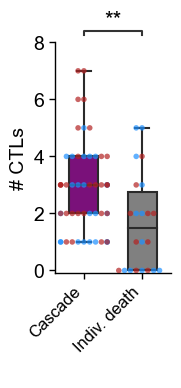

In [12]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1, figsize = (1.5,3))

ax.set_ylim(-0.1,8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='x', labelsize=12, rotation=45)
ax.tick_params(axis='y', labelsize=14)        
ax.tick_params(width=1, length=4)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

order = ['True', 'False']
hue_order = ['apc', 'wt']
    
sns.boxplot(
    data=ALL,
    y='nb_CTLs_50mu',
    x = 'cascade',
    order = order,
    # hue_order = hue_order,
    palette = ['darkmagenta','grey'],
    width = 0.5,
)

sns.swarmplot(    
    data=ALL,
    hue = 'type',
    y='nb_CTLs_50mu',
    x = 'cascade',
    order = order,
    hue_order = hue_order,
    palette = ['firebrick','dodgerblue'],
    size=4,
    alpha = 0.7,
)

add_stat_annotation(ax = ax,
    data=ALL,
    y='nb_CTLs_50mu',
    x = 'cascade',
    order = order,
    box_pairs=[('True', 'False')],
    test='Mann-Whitney', 
    comparisons_correction=None, 
    fontsize = 16,
    text_format='star', loc='outside', verbose=0)

ax.set_xlabel(' ', fontsize = 14)
ax.set_ylabel('# CTLs', fontsize = 14)
labels = ['Cascade', 'Indiv. death']
ax.set_xticklabels(labels, fontsize = 12, ha='right')
ax.get_legend().remove()
plt.show()

In [13]:
cas_prop_wt=CasFilterProperties_(caspase_nucleation[caspase_nucleation.type=='wt'],EP_wt,100,50,0)
cas_prop_apc=CasFilterProperties_(caspase_nucleation[caspase_nucleation.type=='apc'],EP_apc,100,50,0)
cas_prop_wt['P_frac']=cas_prop_wt['frames_P_g']/cas_prop_wt['count_frames']
cas_prop_apc['P_frac']=cas_prop_apc['frames_P_g']/cas_prop_apc['count_frames']
cas_prop_wt['type']='wt'
cas_prop_apc['type']='apc'
event_cascasdes=pandas.concat([cas_prop_wt,cas_prop_apc]).reset_index(drop=True)
event_cascasdes['percent_arrest'] = event_cascasdes['P_frac']*100

cas_prop_wt=CasFilterProperties_(individual_nucleation[individual_nucleation.type=='wt'],EP_wt,100,50,0)
cas_prop_apc=CasFilterProperties_(individual_nucleation[individual_nucleation.type=='apc'],EP_apc,100,50,0)
cas_prop_wt['P_frac']=cas_prop_wt['frames_P_g']/cas_prop_wt['count_frames']
cas_prop_apc['P_frac']=cas_prop_apc['frames_P_g']/cas_prop_apc['count_frames']
cas_prop_wt['type']='wt'
cas_prop_apc['type']='apc'
event_indiv=pandas.concat([cas_prop_wt,cas_prop_apc]).reset_index(drop=True)
event_indiv['percent_arrest'] = event_indiv['P_frac']*100

event_indiv['cascade'] = 'False'
event_cascasdes['cascade'] = 'True'
ALL = pandas.concat([event_indiv, event_cascasdes])

C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 40.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 43.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 19.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarni

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Welch's t-test independent samples, P_val=7.948e-03 stat=-2.766e+00


C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 43.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 19.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


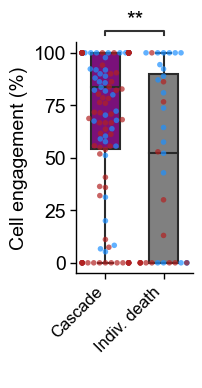

In [14]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1, figsize = (1.5,3))

order = ['True', 'False']
hue_order = ['apc', 'wt']

# ax.set_ylim(0,80)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='x', labelsize=14, rotation=45)
ax.tick_params(axis='y', labelsize=14)        
ax.tick_params(width=1, length=4)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

sns.boxplot(
    x = 'cascade',
    y = 'percent_arrest',
    width = 0.5,
    data=ALL,
    order = order,
    palette = ['darkmagenta','grey'],
)

sns.swarmplot(    
    data=ALL,
    hue = 'type',
    y='percent_arrest',
    x = 'cascade',
    order = order,
    hue_order = hue_order,
    palette = ['firebrick','dodgerblue'],
    size=4,
    alpha = 0.7,
)

add_stat_annotation(ax,
                    data=ALL,   
                    x = 'cascade',
                    y = 'percent_arrest',
                    box_pairs=[('False', 'True')],
                    test='t-test_welch', comparisons_correction=None, 
                    fontsize = 16,
                    text_format='star', loc='outside', verbose=2)

ax.set_xlabel(' ', fontsize = 14)
ax.set_ylabel(r'Cell engagement (%)', fontsize = 14)
labels = ['Cascade', 'Indiv. death']
ax.set_xticklabels(labels, fontsize = 12, ha='right')
ax.get_legend().remove()
plt.show()

# CTLs at the time of cascade nucleation

In [15]:
CTL_on_sph_apc = []
for event in caspase_nucleation_apc.event.unique(): 
    x_casp = caspase_nucleation_apc.loc[caspase_nucleation_apc.event == event, 'x'].item()
    y_casp = caspase_nucleation_apc.loc[caspase_nucleation_apc.event == event, 'y'].item()
    date = caspase_nucleation_apc.loc[caspase_nucleation_apc.event == event, 'date'].item()
    well = caspase_nucleation_apc.loc[caspase_nucleation_apc.event == event, 'well'].item()
    hitting = caspase_nucleation_apc.loc[caspase_nucleation_apc.event == event, 'hitting'].item()
    
    df = copy.copy(tracks_apc.loc[(tracks_apc.date == date) & (tracks_apc.well == well) & (tracks_apc.frame == hitting)])
   
    part, counts = np.unique(df.particle.unique(), return_counts = True)   
    CTL_on_sph_apc.append(len(part))

CTL_on_sph_wt = []
for event in caspase_nucleation_wt.event.unique(): 
    x_casp = caspase_nucleation_wt.loc[caspase_nucleation_wt.event == event, 'x'].item()
    y_casp = caspase_nucleation_wt.loc[caspase_nucleation_wt.event == event, 'y'].item()
    date = caspase_nucleation_wt.loc[caspase_nucleation_wt.event == event, 'date'].item()
    well = caspase_nucleation_wt.loc[caspase_nucleation_wt.event == event, 'well'].item()
    hitting = caspase_nucleation_wt.loc[caspase_nucleation_wt.event == event, 'hitting'].item()
    
    df = copy.copy(tracks_wt.loc[(tracks_wt.date == date) & (tracks_wt.well == well) & (tracks_wt.frame == hitting)])
   
    part, counts = np.unique(df.particle.unique(), return_counts = True)   
    CTL_on_sph_wt.append(len(part))

In [16]:
CTL_on_sph_apc = pandas.DataFrame(CTL_on_sph_apc)
CTL_on_sph_wt = pandas.DataFrame(CTL_on_sph_wt)
CTL_on_sph_apc.columns = ['CTL_on_sph']
CTL_on_sph_wt.columns = ['CTL_on_sph']
CTL_on_sph_apc['type'] = 'apc'
CTL_on_sph_wt['type'] = 'wt'
CTL_on_sph = pandas.concat([CTL_on_sph_apc, CTL_on_sph_wt])

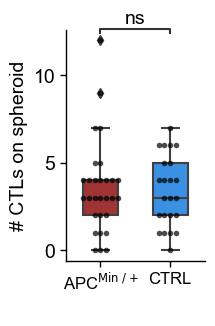

In [17]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1, figsize = (1.8,3))

order = ['apc', 'wt']

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='x', labelsize=12, rotation=0)
ax.tick_params(axis='y', labelsize=14)        
ax.tick_params(width=1, length=4)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

sns.boxplot(ax = ax,
            data=CTL_on_sph,
            x = 'type',
            y='CTL_on_sph',
            order = order,
            width = 0.5,
            palette = ['firebrick', 'dodgerblue'] ,
           )

sns.swarmplot(data=CTL_on_sph,
              x = 'type',
              y='CTL_on_sph',
              color = 'k',
              dodge = True,
              size=4,
              alpha = 0.7,
              order = order,
             )

add_stat_annotation(ax = ax,
                    data=CTL_on_sph,
                    x = 'type',
                    y='CTL_on_sph',
                    order = order,
                    box_pairs=[('wt','apc')],
                    test='t-test_welch', 
                    comparisons_correction=None, 
                    fontsize = 14,
                    text_format='star', loc='outside', verbose=0)

ax.set_ylabel('# CTLs on spheroid', fontsize=14)
ax.set_xlabel(' ', fontsize=14)
labels = [r'APC$^{\mathrm{Min}\ /+}$', 'CTRL']
ax.set_xticklabels(labels, fontsize=12)
plt.show()

# EP in along the experiment

In [18]:
mean_d_apc=EP_apc.groupby(by=['frame']).EP.mean()
std_d_apc=EP_apc.groupby(by=['frame']).EP.std()/np.sqrt(EP_apc.groupby(by=['frame']).EP.count())
mean_d_wt=EP_wt.groupby(by=['frame']).EP.mean()
std_d_wt=EP_wt.groupby(by=['frame']).EP.std()/np.sqrt(EP_wt.groupby(by=['frame']).EP.count())

ep_apc = EP_apc[['EP', 'frame']]
ep_apc['type'] = 'apc'
ep_wt = EP_wt[['EP', 'frame']]
ep_wt['type'] = 'wt'
ep = pandas.concat([ep_apc, ep_wt]).reset_index(drop = True)
ep['time'] = ep['frame']*0.05

C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


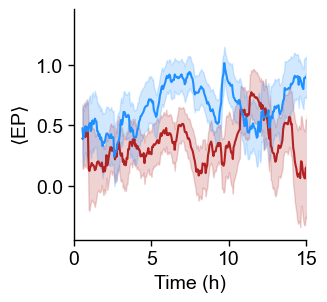

In [19]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1, figsize = (3,3))

# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)

order = ['apc', 'wt']

ax.set_xlim(0,15)
#ax.set_ylim(-0.6,1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)        
ax.tick_params(width=1, length=4)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

sns.lineplot(ax = ax,
    data = ep,
    x = 'time',
    y = 'EP',
    hue = 'type',
    palette = ['firebrick', 'dodgerblue'],
    errorbar = 'se',    
)

ax.set_xlabel('Time (h)', fontsize = 14)
ax.set_ylabel(r'$\langle$EP$\rangle$', fontsize = 14)
ax.get_legend().remove()
plt.show()